## NCBI Blast an assembly output from Megahit or SPAdes against a CoV nucleotide sequence

ASM_file is assembly output from Megablast/CoronaSPAdes

TARGET_FILE is fasta file that want to match assembly to

In [1]:
import os
import collections
import re
import pathlib
from io import StringIO
from Bio.Blast.Applications import NcbiblastnCommandline 
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio import pairwise2  
from Bio.pairwise2 import format_alignment 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from bokeh.plotting import figure, output_notebook, show

In [2]:
DATA_PATH='../Sars_SL3.megahit_kstep10_nomercy_asm/'
FASTA_PATH='../../fasta/'
TARGET_FILE='MN996532_2_RaTG13_complete_genome.fa'
ASM_file='final.contigs.fa'
METHOD='Megahit kstep10 nomercy'
UID='megahit_kstep10_nm'
COV_NAME='RaTG13'
ASM_CODE='SL3_R1'

In [3]:
OUT_PATH=DATA_PATH+'blast_analysis/'
pathlib.Path(OUT_PATH).mkdir(exist_ok=True)

In [4]:
query_file = os.path.join(FASTA_PATH, TARGET_FILE)
subject_file  = os.path.join(DATA_PATH, ASM_file)

In [5]:
assert(os.path.exists(query_file))
assert(os.path.exists(subject_file))

In [6]:
#local BLAST
def search(query_path, database_path):
    query_string = open(query_path).read()
    #percentage identity 95%
    per_id = 95
    blastn_cline = NcbiblastnCommandline(
                                         db=database_path, 
                                         evalue=0.001,
                                         outfmt=5, 
                                         perc_identity=per_id,
                                         max_target_seqs=1, 
                                         num_threads=8)
    out, err = blastn_cline(stdin=query_string)
    io_result = StringIO(out)
    blast_records = list(NCBIXML.parse(io_result))
    for blast_record in blast_records:
        if len(blast_record.alignments) == 0:
            continue
        else:
            alignment = blast_record.alignments[0]
            title = alignment.title
            length = alignment.length
            query_id = blast_record.query
            query_length = blast_record.query_letters
            print(title) 
            print(length)
            print(query_id)
            print(query_length)

Alignment properties: 'accession', 'hit_def', 'hit_id', 'hsps', 'length', 'title'

hsp properties: 'align_length', 'bits', 'expect', 'frame', 'gaps', 'identities', 'match', 
        'num_alignments', 'positives', 'query', 'query_end', 'query_start', 'sbjct', 'sbjct_end', 
        'sbjct_start', 'score', 'strand'

In [7]:
# Run BLAST and parse the output as XML
output = NcbiblastnCommandline(query=query_file, subject=subject_file, outfmt=5)()[0]
blast_result_record = NCBIXML.read(StringIO(output))

seqs={}
lengths=[]
for i, alignment in enumerate(blast_result_record.alignments):
    lengths.append(alignment.length)
    for hsp in alignment.hsps:
        seqs[i]=[hsp.query_start, hsp.query_end, alignment.title, hsp.sbjct]
print(f'{len(seqs)} sequences in assembly file {subject_file} were found to match {query_file}, lengths: {lengths} ')
        

21 sequences in assembly file ../Sars_SL3.megahit_kstep10_nomercy_asm/final.contigs.fa were found to match ../../fasta/MN996532_2_RaTG13_complete_genome.fa, lengths: [3867, 2506, 2232, 2141, 1995, 1706, 1476, 1279, 1168, 1012, 984, 964, 738, 675, 663, 537, 499, 494, 442, 379, 302] 


In [8]:
seqs.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [9]:
if len(seqs)==0:
    print('No matches found, halting workflow')
    raise ValueError

Create a numpy array (faster than pandas dataframe) of size required and fill rows with sequences, then user to build final sequence from assemblies

In [10]:
fasta_target = SeqIO.read(query_file, format="fasta")
fasta_target

SeqRecord(seq=Seq('ATTAAAGGTTTATACCTTTCCAGGTAACAAACCAACGAACTCTCGATCTCTTGT...AAA'), id='MN996532.2', name='MN996532.2', description='MN996532.2 Bat coronavirus RaTG13, complete genome', dbxrefs=[])

In [11]:
fasta_seq=str(fasta_target.seq)
fasta_title=fasta_target.description

Add 1 row for target sequence, add column for title

In [12]:
seq_array=np.tile('-', (len(seqs)+1, len(fasta_seq)))
title_array=np.empty(len(seqs)+1, dtype='str')
seq_array=seq_array.astype('str')

In [13]:
assert seq_array.shape[1]==len(fasta_seq)

In [14]:
seq_array[0]=list(fasta_seq)

In [15]:
title_array[0]=fasta_title
assert seq_array.shape[0]==title_array.shape[0]

In [16]:
def problem_sequence_gen(start, end, title, subject, target_length):
    ''' 
    Blast on some CoronaSPAdes assemblies generates anomalous outputs
    where hsp.end-hsp.start != len(sequence)
        Either:
        1) start wrong
        2) end wrong
        3) actual sequence not fully used by blast? (where sequence too long)
        
    Here we assume 
        i) if sequence too long, that start and end are correct ie truncate sequence end
        ii) if sequence too short, that start and sequence length are correct
    '''

    expected_len=end-(start-1)
    expected_end=start+len(subject)-1
    subject_len_diff=expected_len-len(subject)
    #make independent copy of subject
    subject_mod = ''.join(subject)
    if subject_len_diff>0:
        #expected length longer than actual, ie sequnce too short
        SEQ_LONG=False
        print(f'WARNING sequence too short by {abs(subject_len_diff)} characters, \
        assuming that start and sequence length are correct')
    else:
        SEQ_LONG=True
        print(f'WARNING sequence too long by {abs(subject_len_diff)} characters, \
        truncating sequence end!')
    row=['-'] * (start-1)
    if SEQ_LONG:
        trailer=['-'] * (target_length-end)
        subject_mod=subject_mod[:len(subject_mod) - abs(subject_len_diff)]
    else:
        trailer=['-'] * (target_length-expected_end)
    subject_chars=list(subject_mod)
    row.extend(subject_chars)
    row.extend(trailer)
    if not(len(row)==target_length):
        print(f'built row length: {len(row)}, target length: {target_length}, \
        start: {start}, end: {end}, subject length {len(subject)}, mod subject length: {len(subject_mod)}')
    return row
    

In [17]:
def create_sequence(start, end, title, subject, target_length):
    if not((end-(start-1))==len(subject)):
        return problem_sequence_gen(start, end, title, subject, target_length)
    row=['-'] * (start-1)
    assert end==start+len(subject)-1
    trailer=['-'] * (target_length-end)
    subject_chars=list(subject)
    row.extend(subject_chars)
    row.extend(trailer)
    assert len(row)==target_length
    return row

In [18]:
seq_rows=[]
lengths=[]
for k,v in seqs.items():
    #start,end,title,subject
    row=create_sequence(v[0], v[1], v[2], v[3], len(fasta_seq))
    lengths.append(len(v[3]))
    seq_rows.append(row)
#seq_rows.sort()

In [19]:
length_sorted=[x for _,x in sorted(zip(lengths,seq_rows), reverse=True)]
titles_sorted=[x for x in length_sorted[2]]

replace empty values in numpy arry - sorted by length of sequence, row 0 being the target sequence
titles are stored in a separate array

In [20]:
i=0
for l,t in zip(length_sorted,titles_sorted):
    seq_array[i+1]=l
    title_array[i+1]=t
    i+=1

In [21]:
seq_array[0]

array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1')

### Check against target

In [22]:
#keep all but target in row 0
nn_only = seq_array[1:]
target=seq_array[0]
equal_checks=np.empty([nn_only.shape[0], nn_only.shape[1]])
for i in range(np.shape(nn_only)[0]):
    #get row
    seq_cmp=nn_only[i]
    equal_check = seq_cmp == target
    equal_check = equal_check.astype(int)
    mask = np.isin(seq_cmp, ['-'])
    #set empty (true) to be 2 temporarily
    equal_check[mask]=2
    equal_checks[i]=equal_check

Swap 2 ('-' ie empty) to be 0

In [23]:
equal_checks[equal_checks == 0] = 3
equal_checks[equal_checks == 2] = 0
equal_checks[equal_checks == 3] = 2

assert (np.count_nonzero(equal_checks == 3))==0

In [24]:
def plot_blocked_seq(stack_arr, name='sequences_blocked.png', cmap='CMRmap_r'):
    print(f'>>plot_blocked_seq, stack_arr: {stack_arr.shape}')
    fig= plt.figure(figsize=(20,6))
    plt.imshow(stack_arr, cmap=plt.get_cmap(cmap))
    ax = plt.gca()
    ax.axes.yaxis.set_visible(False)
    plt.savefig(name, dpi=600)
    plt.show()

### Merge into single sequence

Where only single seuence has coverage - use that
Where 2 or more sequences cover same NN - if NN same, use that, if NN's differ and more of 1 then other use that, if differ and equal number, then use the one that matches the target

In [25]:
#TODO refactor to remove code duplaction
nn_only = seq_array[1:]
asm_build=[]
col_idx=0
for column in nn_only.T:
    unique, frequency = np.unique(column,  
                              return_counts = True) 
    if len(unique)==1:
        assert frequency==nn_only.shape[0]
        asm_build.append(unique[0])
    elif len(unique)==2:
        if '-' in unique:
            #highly unlikely this wont be case for this dataset
            not_empty = [x for x in unique if x != '-']
            asm_build.append(not_empty[0])
        else:
            if frequency[0]==frequency[1]:
                #give benefit of doubt
                if unique[0]==seq_array[0][col_idx]:
                    asm_build.append(unique[0])
                else:
                    asm_build.append(unique[1])
            else:
                #if not equal fequency then get the most common
                max_freq = numpy.where(frequency == numpy.amax(frequency)) 
                asm_build.append(unique[max_freq])
    elif len(unique)==3:
        if '-' in unique:
            not_empty = [x for x in unique if x != '-']
            temp_idxs=list(range(3))
            empty_idx = np.where(unique == '-')
            e_idx_val=empty_idx[0][0]
            del temp_idxs[e_idx_val] 
            if frequency[temp_idxs[0]]==frequency[temp_idxs[1]]:
                #give benefit of doubt
                if unique[temp_idxs[0]]==seq_array[0][col_idx]:
                    asm_build.append(unique[temp_idxs[0]])
                else:
                    asm_build.append(unique[temp_idxs[1]])
            else:
                #if not equal fequency then get the most common
                temp_freq=frequency.copy()
                del temp_freq[empty_idx] 
                max_freq = numpy.where(temp_freq == numpy.amax(temp_freq)) 
                asm_build.append(unique[max_freq])
        else:
            raise NotImplementedError
    elif len(unique)>3:
        if '-' in unique:
            not_empty = [x for x in unique if x != '-']
            temp_idxs=list(len(unique))
            empty_idx = np.where(unique == '-')
            e_idx_val=empty_idx[0][0]
            del temp_idxs[e_idx_val] 
            temp_freq=frequency.copy()
            del temp_freq[empty_idx] 
            max_freq = numpy.where(temp_freq == numpy.amax(temp_freq)) 
            asm_build.append(unique[max_freq])
        else:
            max_freq = numpy.where(frequency == numpy.amax(frequency)) 
            asm_build.append(unique[max_freq])
    col_idx+=1

In [26]:
len(asm_build)

29855

In [27]:
def ord_convert(x):
    '''convert each character in array to its integer representation'''
    return ord(x)
ord_v = np.vectorize(ord_convert)

Convert to integers to plot

In [28]:
data_ord=ord_v(asm_build)
#replace '-' (empty), with 0
data_ord[data_ord == 45] = 0

In [29]:
#convert to 2D so can plot
stacked=np.stack([data_ord, data_ord], axis=0)

>>plot_blocked_seq, stack_arr: (1000, 29855)


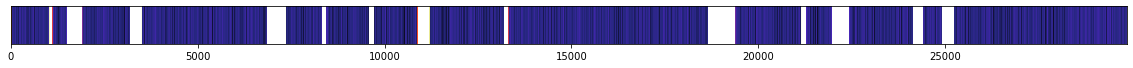

In [30]:
stacked_repeated = np.repeat(stacked, repeats=500, axis=0)
plot_blocked_seq(stacked_repeated, name=OUT_PATH+f'asm_stitched_{UID}.png')

In [31]:
target=seq_array[0]

asm_check = asm_build == target
asm_check = asm_check.astype(int)
mask = np.isin(asm_build, ['-'])
#set empty (true) to be 2 temporarily
asm_check[mask]=2
asm_check[asm_check == 0] = 3
asm_check[asm_check == 2] = 0
asm_check[asm_check == 3] = 2
#0: empty; 1: NN match, 2: NN incorrect (based on consensus id more than 1)


In [32]:
unique, frequency = np.unique(asm_check,  
                              return_counts = True) 
print(f'unique: {unique}, frequency: {frequency}')

unique: [0 1 2], frequency: [ 3944 25885    26]


In [33]:
def export_fasta(out_file_path, sequence, id_text, description):
    if isinstance(sequence, list):
        sequence = ''.join(sequence)
    seq=Seq(sequence)
    record=SeqRecord(seq, id=id_text, description=description)
    with open(out_file_path, "w") as output_handle:
        SeqIO.write(record, output_handle, "fasta")

In [34]:
export_fasta(OUT_PATH+f'{COV_NAME}_{ASM_CODE}_{UID}.fa', asm_build, f'{COV_NAME}_{ASM_CODE}_{UID}', METHOD)

### Stats

In [35]:
correct_seq=f'Percentage of full sequence with correct sequence coverage: {(frequency[1]/len(fasta_seq))*100}%'

greater than 1 where segments overlp

In [36]:
correct_overlap=f'Percentage of full sequence with correct overlapping sequences: {(frequency[2]/len(fasta_seq))*100}%'

In [37]:
missing=f'Percentage missing: {(frequency[0]/len(fasta_seq))*100}%'

In [38]:
print(correct_seq)
print(correct_overlap)
print(missing)

Percentage of full sequence with correct sequence coverage: 86.70239490872551%
Percentage of full sequence with correct overlapping sequences: 0.08708759001842237%
Percentage missing: 13.210517501256072%


In [39]:
with open(OUT_PATH+f"{COV_NAME}_{ASM_CODE}_{UID}_stats.txt", "w") as text_file:
    text_file.write(correct_seq +'\n')
    text_file.write(correct_overlap +'\n')
    text_file.write(missing +'\n')

#### Plot

Top row: Red- one sequence correct, black- 2 or more sequences correct, white- no coverage

Bottom row: Red - equence sampled but NN incorrect

In [40]:
equal_checks.shape

(21, 29855)

In [41]:
bin_stacked_repeated = np.repeat(stacked, repeats=250, axis=0)
bin_stacked_repeated[bin_stacked_repeated > 0] = 1

#add a gap
bin_zero_repeated = np.repeat(stacked, repeats=250, axis=0)
bin_zero_repeated[bin_stacked_repeated > 0] = 0
stacked_header=np.stack([bin_stacked_repeated, bin_zero_repeated], axis=0)

In [42]:
stacked_header=stacked_header.reshape((bin_stacked_repeated.shape[0]+bin_zero_repeated.shape[0], bin_zero_repeated.shape[1]))

In [43]:
equal_repeated = np.repeat(equal_checks, repeats=500, axis=0)
stack_arr=np.concatenate((stacked_header,equal_repeated), axis=0)

>>plot_blocked_seq, stack_arr: (11500, 29855)


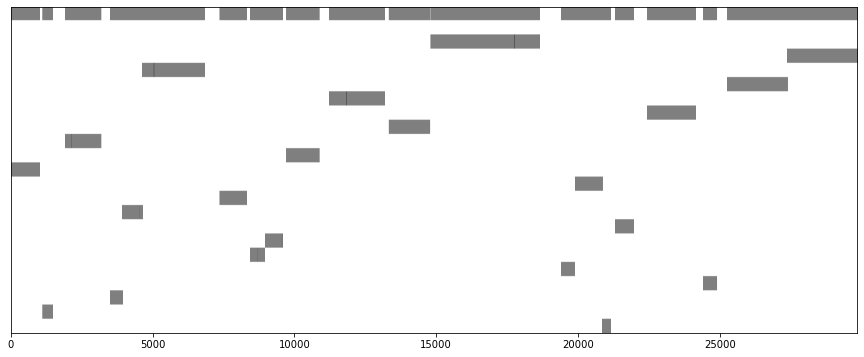

In [44]:
plot_blocked_seq(stack_arr, name=OUT_PATH+f'equal_repeated_{UID}.png', cmap='gray_r')

### Misc Plotting

In [45]:
nn_unique=np.unique(seq_array)
ord_unique=np.unique(ord_v(seq_array))
unique_codes = dict(zip(list(range(len(ord_unique))), ord_unique))

In [46]:
def replce_npy(a, val_list, replace_with):
    for v,r in zip(val_list, replace_with):
        [[_el if _el == v else r for _el in _ar] for _ar in a]

In [47]:
def get_plot_data(seq_array, unique_codes, labels):
    data_ord=ord_v(seq_array)
    unique, frequency = np.unique(seq_array,  
                              return_counts = True) 
    print(f'Unique Nucleotides: {unique}, frequency: {frequency}')
    for n,o in zip(nn_unique, ord_unique):
        #use the unique NN code (order unknown) as loopup in the colourbar list
        idx=np.where(labels == n.upper())
        #key = next(key for key, value in dd.items() if value == v)
        data_ord=np.where(data_ord==o, idx, data_ord)
    #repeat to expand y axis 
    data_repeated = np.repeat(data_ord, repeats=500, axis=0)
    return data_repeated

In [48]:
def plot_nn_colourbars():
    #after https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar

    col_dict={0:"white",
              1:"blue",
              2:"yellow",
              3:"red",
              4:"green",
              5:"magenta",
              6:"black",
              7:"tan",
              8:"darkgreen",
              9:"lavender",
              10:"lightcoral",
              11:"aquamarine",
              12:"lightcyan",
              13:"orchid",
              14:"coral",
              15:"olive",
              16:"lightblue"
             }

    # create a colormap from our list of colors
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

    #in order of here: https://www.genome.jp/kegg/catalog/codes1.html
    labels = np.array(["-","A","G","C","T","U","R","Y","N","W", "S","M","K","B","H","D","V"])
    len_lab = len(labels)

    # prepare normalizer
    norm_bins = np.sort([*col_dict.keys()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

    norm = mpl.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
    fmt = mpl.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

    data_repeated=get_plot_data(seq_array, unique_codes, labels)

    #plt.matshow(data_repeated, cmap=cm, norm=norm)

    fig,ax = plt.subplots(figsize=(20, 10))
    
    im = ax.imshow(data_repeated, cmap=cm, norm=norm)

    ax.axes.yaxis.set_visible(False)
    diff = norm_bins[1:] - norm_bins[:-1]
    tickz = norm_bins[:-1] + diff / 2
    cb = fig.colorbar(im, format=fmt, ticks=tickz)
    ax.axes.yaxis.set_visible(False)
    plt.title(f'Target: {TARGET_FILE} (top row) vs contigs using {METHOD}', fontsize=12)
    fig.savefig(OUT_PATH+f"colour_sequence_map_{UID}.png")
    plt.show()

Unique Nucleotides: ['-' 'A' 'C' 'G' 'T'], frequency: [600922  16746  10391  10965  17786]


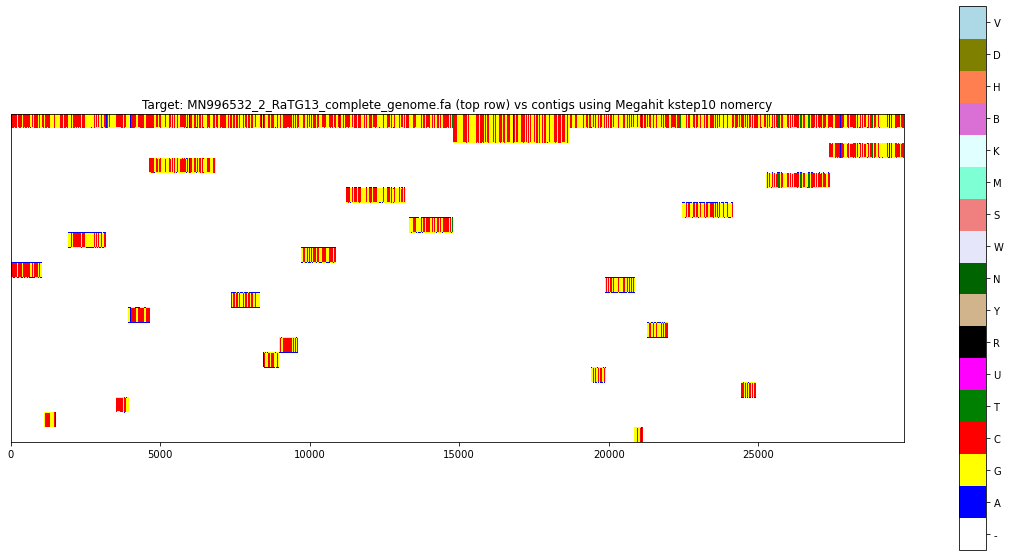

In [49]:
#TODO, use bokeh for revised version so can zoom and explore
plot_nn_colourbars()

(array([8922.,    0.,    0., 9579.,    0.,    0., 5847.,    0.,    0.,
        5507.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

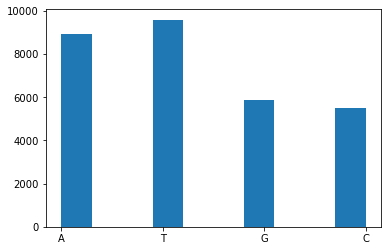

In [50]:
#odd that plot above looks like mostly G & C
plt.hist(seq_array[0])